<a href="https://colab.research.google.com/github/mvajhi/unsupervised-learning/blob/master/HW3/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


length of the training set: 60000
length of the test set: 10000


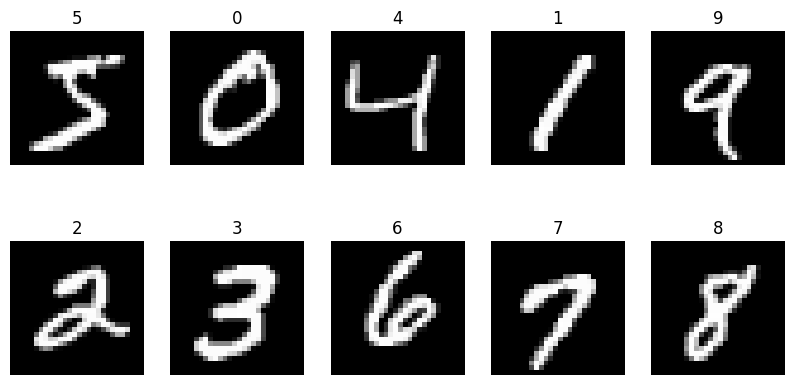

In [2]:
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = torchvision.transforms.ToTensor()
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print('length of the training set: {}'.format(len(mnist_trainset)))
print('length of the test set: {}'.format(len(mnist_testset)))


figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
displayed_labels = []

for img, label in mnist_trainset:
    if len(displayed_labels) == 10:
        break
    if label not in displayed_labels:
        ax = figure.add_subplot(rows, cols, len(displayed_labels) + 1)
        ax.set_title((label))
        ax.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
        displayed_labels.append(label)

plt.show()

# Preprocessing Step

برای انتخاب ۲۰۰ داده ۲۰۰ کلاستر می کنیم داده های آموزشی را سپس داده مرکزی هر کلاستر را انتخاب می کنیم. به این صورت ۲۰۰ داده خوبی را انتخاب کردیم.

In [3]:
from sklearn.cluster import KMeans
from scipy.spatial import distance
import numpy as np
from tqdm import tqdm

train_images_np = mnist_trainset.data.numpy()
train_labels_np = mnist_trainset.targets.numpy()
test_images_np = mnist_testset.data.numpy()
test_labels_np = mnist_testset.targets.numpy()

n_samples, nx, ny = train_images_np.shape
train_images_flattened = train_images_np.reshape((n_samples, -1))


n_clusters = 200
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(train_images_flattened)

selected_indices = []

distances = kmeans.transform(train_images_flattened)

for i in tqdm(range(n_clusters), desc="select sample"):
    indices_in_cluster = np.where(kmeans.labels_ == i)[0]
    cluster_distances = distances[indices_in_cluster, i]
    index_of_closest_in_cluster = np.argmin(cluster_distances)
    original_index = indices_in_cluster[index_of_closest_in_cluster]
    selected_indices.append(original_index)

all_indices = np.arange(len(train_images_np))
unlabeled_indices = np.setdiff1d(all_indices, selected_indices)

train_x = train_images_np[selected_indices]
train_y_raw = train_labels_np[selected_indices]

train_unlabeled = train_images_np[unlabeled_indices]

test_x = test_images_np
test_y_raw = test_labels_np

select sample: 100%|██████████| 200/200 [00:00<00:00, 15482.28it/s]


In [4]:
from sklearn.preprocessing import OneHotEncoder

def one_hot(y):
  #For converting a numpy array of 0-9 into a one hot encoding of vectors of length 10
  b = np.zeros((y.size, y.max() + 1))
  b[np.arange(y.size), y] = 1
  return b.astype(np.float32)

train_y = one_hot(train_y_raw)
test_y = one_hot(test_y_raw)

train_x = train_x.reshape(train_x.shape[0], 1, 28, 28).astype(np.float32)
train_unlabeled = train_unlabeled.reshape(train_unlabeled.shape[0], 1, 28, 28).astype(np.float32)
test_x = test_x.reshape(test_x.shape[0], 1, 28, 28).astype(np.float32)

torch_train_x = torch.tensor(train_x, requires_grad=True).to(device)
torch_train_y = torch.tensor(train_y).to(device)
torch_test_x = torch.tensor(test_x, requires_grad=True).to(device)
torch_test_y = torch.tensor(test_y).to(device)
torch_train_unlabeled = torch.tensor(train_unlabeled, requires_grad=True).to(device)

# Defining Model

In [8]:
import torch.nn.functional as F
import torch.nn as nn

class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3)
        self.conv2 = nn.Conv2d(16,16,3)
        self.conv3 = nn.Conv2d(16,32,3)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1)
        return x

#defining model head
class Head(nn.Module):
    def __init__(self, n_class=10):
        super(Head, self).__init__()
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, n_class)

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = Backbone()
        self.head = Head()

        if torch.cuda.is_available():
            self.cuda()

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model_baseline = Model()
print(model_baseline(torch_train_x[:1]).shape)
model_baseline

torch.Size([1, 10])


Model(
  (backbone): Backbone(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (head): Head(
    (fc1): Linear(in_features=32, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=10, bias=True)
  )
)

# Train without unlabeled data

100%|██████████| 2500/2500 [01:27<00:00, 28.42it/s]


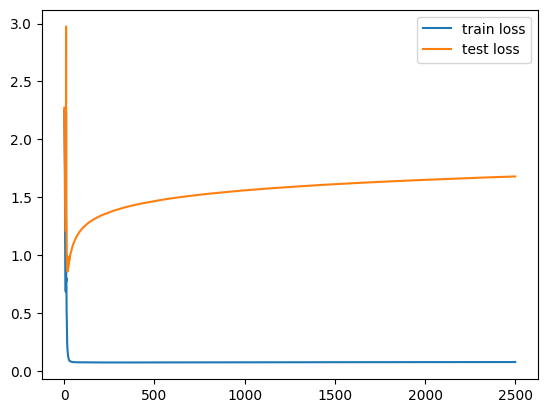

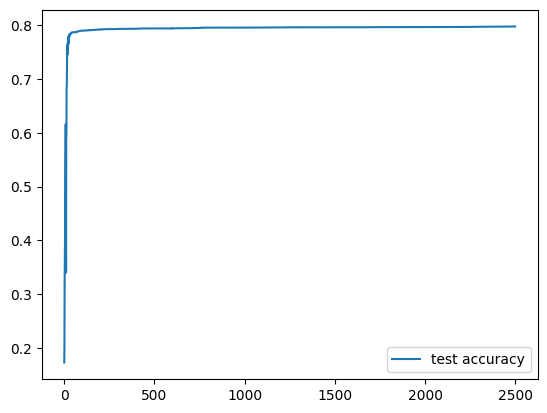

max accuracy: 0.7973


In [9]:
def supervised_train(model):

    batch_size = 32
    lr = 0.001
    momentum = 0.9
    num_epochs = 2500

    #defining a stocastic gradient descent optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    #defining loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    train_hist = []
    test_hist = []
    test_accuracy = []

    for epoch in tqdm(range(num_epochs)):

        #iterating over all batches
        for i in range(int(len(train_x)/batch_size)-1):

            #Put the model in training mode, so that things like dropout work
            model.train(True)


            # Zero gradients for the optimizer
            optimizer.zero_grad()


            #extracting X and y values from the batch
            X = torch_train_x[i*batch_size: (i+1)*batch_size]
            y = torch_train_y[i*batch_size: (i+1)*batch_size]

            # Make predictions for this batch
            y_pred = model(X)

            #compute gradients with the loss function
            loss = loss_fn(y_pred, y)
            loss.backward()


            # Adjust learning weights
            optimizer.step()

        with torch.no_grad():

            #Disable things like dropout, if they exist
            model.train(False)

            #calculating epoch training and test loss
            train_loss = loss_fn(model(torch_train_x), torch_train_y).cpu().numpy()
            y_pred_test = model(torch_test_x)
            test_loss = loss_fn(y_pred_test, torch_test_y).cpu().numpy()

            train_hist.append(train_loss) # use train loss to plot
            test_hist.append(test_loss) # use test loss to plot

            #computing test accuracy
            matches = np.equal(np.argmax(y_pred_test.cpu().numpy(), axis=1), np.argmax(torch_test_y.cpu().numpy(), axis=1))
            test_accuracy.append(np.mean(matches))

    import matplotlib.pyplot as plt
    plt.plot(train_hist, label = 'train loss')
    plt.plot(test_hist, label = 'test loss')
    plt.legend()
    plt.show()
    plt.plot(test_accuracy, label = 'test accuracy')
    plt.legend()
    plt.show()

    maxacc = np.max(test_accuracy)
    print('max accuracy: {}'.format(maxacc))

    return maxacc

supervised_maxacc = supervised_train(model_baseline)

بله، دقت به دست آمده مشخصا بالاتر از Chance Level هست.

# Data Augmentation

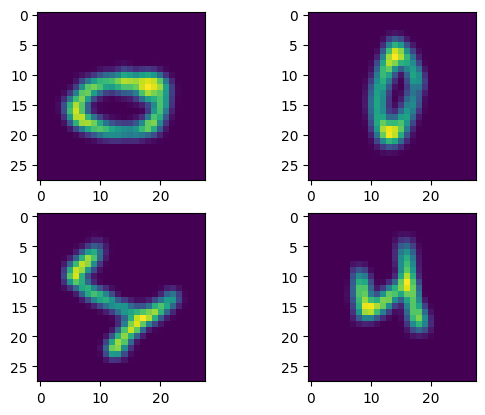

In [12]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

class Augment:

   def __init__(self):

       blur = T.GaussianBlur((3,3))

       self.train_transform = torch.nn.Sequential(
           T.RandomAffine(45),
           T.RandomPerspective(),
           T.RandomPerspective(),
           T.RandomPerspective(0.2,0.5),
           T.RandomApply([blur]),
           T.RandomApply([blur])
       )

   def __call__(self, x):
       return self.train_transform(x), self.train_transform(x)

"""
Generating Test Augmentation
"""
a = Augment()
aug = a(torch_train_unlabeled[0:100])

i=1
f, axarr = plt.subplots(2,2)
#positive pair
axarr[0,0].imshow(aug[0].cpu().detach().numpy()[i,0])
axarr[0,1].imshow(aug[1].cpu().detach().numpy()[i,0])
#another positive pair
axarr[1,0].imshow(aug[0].cpu().detach().numpy()[i+1,0])
axarr[1,1].imshow(aug[1].cpu().detach().numpy()[i+1,0])
plt.show()

# Defining Contrastive Loss

In [14]:
class ContrastiveLoss(nn.Module):
   def __init__(self, batch_size, temperature=0.5):

       super().__init__()
       self.batch_size = batch_size
       self.temperature = temperature
       self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(device)

   def calc_similarity_batch(self, a, b):
       representations = torch.cat([a, b], dim=0)
       return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

   def forward(self, proj_1, proj_2):
       batch_size = proj_1.shape[0]
       z_i = F.normalize(proj_1, p=2, dim=1)
       z_j = F.normalize(proj_2, p=2, dim=1)

       similarity_matrix = self.calc_similarity_batch(z_i, z_j)

       sim_ij = torch.diag(similarity_matrix, batch_size)
       sim_ji = torch.diag(similarity_matrix, -batch_size)

       positives = torch.cat([sim_ij, sim_ji], dim=0)

       nominator = torch.exp(positives / self.temperature)

       denominator = self.mask * torch.exp(similarity_matrix / self.temperature)

       all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
       loss = torch.sum(all_losses) / (2 * self.batch_size)
       return loss

loss = ContrastiveLoss(200)
fake_proj_0, fake_proj_1 = a(torch_train_x)
fake_proj_0 = fake_proj_0[:,0,:,0]
fake_proj_1 = fake_proj_1[:,0,:,0]
loss(fake_proj_0, fake_proj_1)

tensor(5.9957, device='cuda:0', grad_fn=<DivBackward0>)

# Training on whole data

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

model = Model()
model.train()

#defining key hyperparameters
batch_size = 512
epoch_size = int(len(torch_train_unlabeled) / batch_size)
num_epochs = 75
patience = 5
cutoff_ratio = 0.001

#defining key learning functions
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_examples = len(torch_train_unlabeled)
lossfn = ContrastiveLoss(num_examples)
augmentfn = Augment()

#for book keeping
loss_hist = []
improvement_hist = []
schedule_hist = []

#for exponentially decreasing learning rate
scheduler = ExponentialLR(optimizer, gamma = 0.95)

#for early stopping
patience_count = 0

#Training Loop
avg_loss = 1e10
for i in range(num_epochs):

    print('epoch {}/{}'.format(i,num_epochs))

    total_loss = 0
    loss_change = 0

    for j in tqdm(range(epoch_size)):

        #getting random batch
        X = torch_train_unlabeled[j*batch_size: (j+1)*batch_size]

        #creating pairs of augmented batches
        X_aug_i, X_aug_j = augmentfn(x)

        #ensuring gradients are zero
        optimizer.zero_grad()

        #passing through the model
        z_i = model()
        z_j = model()

        #calculating loss on the model embeddings, and computing gradients
        loss = lossfn(z_i, z_j)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        if True:
            z_i = model(X_aug_i)
            z_j = model(X_aug_j)

            #calculating new loss value
            new_loss = lossfn(z_i, z_j)

            loss_change += new_loss.cpu().detach().numpy() - loss.cpu().detach().numpy()

        total_loss += loss_change

        #step learning rate scheduler
        schedule_hist.append(scheduler.get_last_lr())

    #########################
    # update scheduler here #
    scheduler.step()
    #########################

    #calculating percentage loss reduction
    new_avg_loss = total_loss/epoch_size
    per_loss_reduction = (avg_loss-new_avg_loss)/avg_loss
    print('Percentage Loss Reduction: {}'.format(per_loss_reduction))

    #deciding to stop if loss is not decreasing fast enough
    if per_loss_reduction < cutoff_ratio:
        patience_count+=1
        print('patience counter: {}'.format(patience_count))
        if patience_count > patience:
            break
    else:
        patience_count = 0

    #setting new loss as previous loss
    avg_loss = new_avg_loss

    #book keeping
    avg_improvement = loss_change/epoch_size
    loss_hist.append(avg_loss)
    improvement_hist.append(avg_improvement)
    print('Average Loss: {}'.format(avg_loss))
    print('Average Loss change (if calculated): {}'.format(avg_improvement))

In [ ]:
plt.plot(schedule_hist, label='learning rate')
plt.legend()
plt.show()
plt.plot(loss_hist, label = 'loss')
plt.legend()
plt.show()